In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from gpcg import GPCGSolver

# Example 1: deblurring with nonnegativity constraint (1D)

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 5*1e0
blur_sigma = 1.5
noise_sigma = 0.2

# Create signal
def eval_signal(x):
    if x < 0.2:
        return 0
    elif (x >= 0.2) and (x < 0.4):
        return 1 
    elif (x >= 0.4) and (x < 0.6):
        return 0
    elif (x >= 0.6) and (x < 0.8):
        return 2
    elif (x >= 0.8) and (x <= 1.0):
        return 0
    else:
        return 0

vecfunc = np.vectorize(eval_signal)
dom = np.linspace(0, 1, 100)
x = vecfunc( dom ) + np.sin(5*dom)

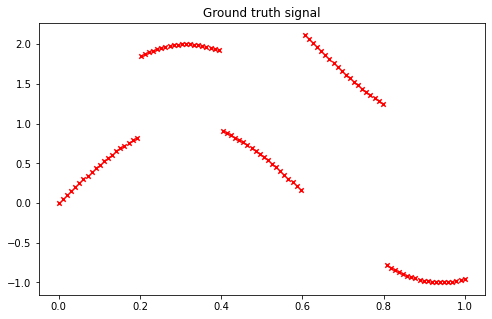

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [4]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
def build_1d_first_order_grad(N: int, 
    boundary: str = "periodic",
):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "periodic", "zero"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=-1)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[0,-1] = -1
    elif boundary == "zero":
        pass
    elif boundary == "none":
        d_mat = d_mat[1:,:]
    else:
        pass
    
    return d_mat

rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (F.T @ F) + reg_lambda*(R.T @ R)

In [5]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg, _ = scipy_cg(Q, F.rmatvec(y) , maxiter=1e5)

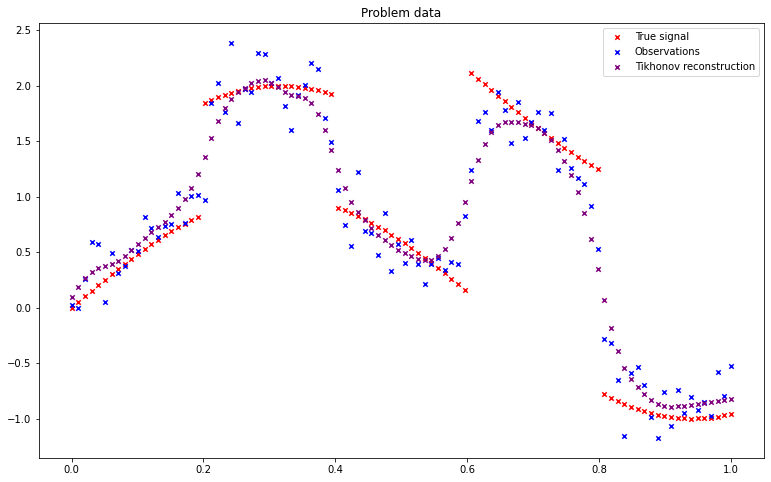

In [6]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

In [13]:
# Solve problem with gpcg
lower_bounds = np.zeros(Q.shape[0])
upper_bounds = np.inf*np.ones(Q.shape[0])
solver = GPCGSolver(Q, F.rmatvec(y), lower_bounds=lower_bounds, upper_bounds=upper_bounds)
gpcg_solution = solver.solve(maxits=100, tol=1e-4)
print("Converged?" + " " + str(gpcg_solution["converged"]) )

Converged? True


In [14]:
# Also solve with scipy minimize for comparison
bnds = []
for j, item in enumerate(lower_bounds):
    bnds.append( ( lower_bounds[j], upper_bounds[j] ) )

fun = lambda x: 0.5*(x.T @ (Q @ x) ) - (F.rmatvec(y) @ x)
    
scipy_sol = res = minimize(fun, np.ones(len(lower_bounds)), bounds=bnds, tol=1e-10).x

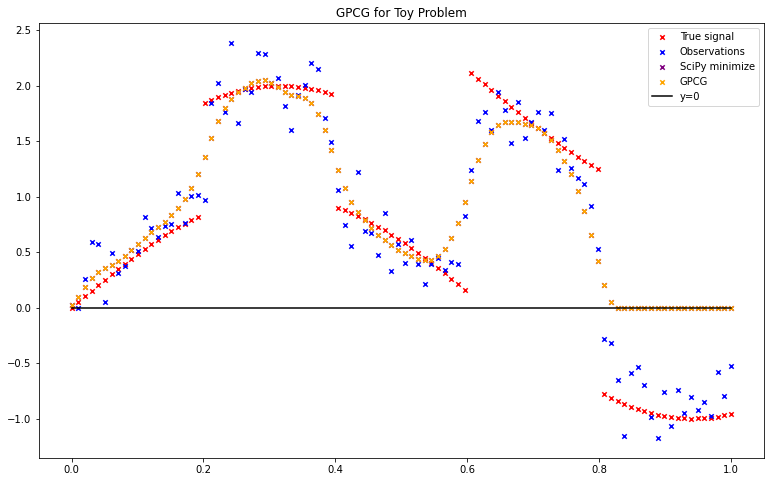

In [16]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_sol, marker="x", color="purple", s=20.0, label="SciPy minimize")
plt.scatter(dom, gpcg_solution["x"], marker="x", color="orange", s=20.0, label="GPCG")
plt.plot(np.linspace(0, 1, 100), 0*np.linspace(0, 1, 100), label="y=0", color="black" )
plt.legend()
plt.title("GPCG for Toy Problem")
plt.show()

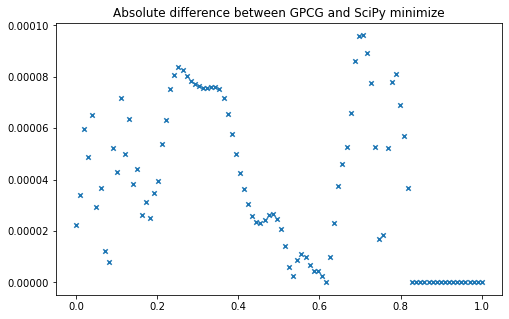

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(dom, np.abs( gpcg_solution["x"] - scipy_sol ), marker="x", s=20)
plt.title("Absolute difference between GPCG and SciPy minimize")
plt.show()

# Example 2: deblurring with nonnegativity constraint (2D)